# ESIEE Paris — Data Engineering I — Assignment 3
> Author : Badr TAJINI

**Academic year:** 2025–2026  
**Program:** Data & Applications - Engineering - (FD)   
**Course:** Data Engineering I  

---

## Learning goals
- Analyze with **SQL** and **DataFrames**.
- Implement two **RDD means** variants.
- Implement **RDD joins** (shuffle and hash).
- Record and explain performance observations.


## 1. Setup

Download data files from the following URL:
https://www.dropbox.com/scl/fi/7012u693u06dgj95mgq2a/retail_dw_20250826.tar.gz?rlkey=fxyozuoryn951gzwmli5xi2zd&dl=0

Unpack somewhere and define the `data_path` accordingly:

In [10]:
# Change to path on your local machine.
data_path = "data/"

The following cell contains setup to measure wall clock time and memory usage. (Don't worry about the details, just run the cell)

In [7]:
!pip install -U numpy pandas pyarrow matplotlib scipy
import sys, subprocess
try:
    import psutil  # noqa: F401
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "psutil"])
print("psutil is installed.")


from IPython.core.magic import register_cell_magic
import time, os, platform

# Try to import optional modules
try:
    import psutil
except Exception:
    psutil = None

try:
    import resource  # not available on Windows
except Exception:
    resource = None


def _rss_bytes():
    """Resident Set Size in bytes (cross-platform via psutil if available)."""
    if psutil is not None:
        return psutil.Process(os.getpid()).memory_info().rss
    # Fallback: unknown RSS → 0 
    return 0


def _peak_bytes():
    """
    Best-effort peak memory in bytes.
    - Windows: psutil peak working set (peak_wset)
    - Linux:   resource.ru_maxrss (KB → bytes)
    - macOS:   resource.ru_maxrss (bytes)
    Fallback to current RSS if unavailable.
    """
    sysname = platform.system()

    # Windows path: use psutil peak_wset if present
    if sysname == "Windows" and psutil is not None:
        mi = psutil.Process(os.getpid()).memory_info()
        peak = getattr(mi, "peak_wset", None)  # should be available on Windows
        if peak is not None:
            return int(peak)
        return int(mi.rss)

    # POSIX path: resource may be available
    if resource is not None:
        try:
            ru = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
            # On Linux ru_maxrss is in kilobytes; on macOS/BSD it is bytes
            if sysname == "Linux":
                return int(ru) * 1024
            else:
                return int(ru)
        except Exception:
            pass

    # Last resort
    return _rss_bytes()


@register_cell_magic
def timemem(line, cell):
    """
    Measure wall time and memory around the execution of this cell.

        %%timemem
        <your code>

    Notes:
    - RSS = resident memory after the cell.
    - Peak is OS-dependent (see _peak_bytes docstring).
    """
    ip = get_ipython()

    rss_before  = _rss_bytes()
    peak_before = _peak_bytes()
    t0 = time.perf_counter()

    # Execute the cell body
    result = ip.run_cell(cell)

    t1 = time.perf_counter()
    rss_after  = _rss_bytes()
    peak_after = _peak_bytes()

    wall = t1 - t0
    rss_delta_mb  = (rss_after  - rss_before)  / (1024 * 1024)
    peak_delta_mb = (peak_after - peak_before) / (1024 * 1024)

    print("======================================")
    print(f"Wall time: {wall:.3f} s")
    print(f"RSS Δ: {rss_delta_mb:+.2f} MB")
    print(f"Peak memory Δ: {peak_delta_mb:+.2f} MB (OS-dependent)")
    print("======================================")

    return result

psutil is installed.


The following code snippet should "just work" to initialize Spark.

In [4]:
import findspark, os, sys

# Change to path on your local machine.
os.environ["SPARK_HOME"] = "/home/justine/spark-4.0.1-bin-hadoop3"
findspark.init()

from pyspark.sql import SparkSession, functions as F, Window
from pyspark.sql.functions import broadcast

py = sys.executable  # the Python of this notebook (e.g., .../envs/yourenv/bin/python)
os.environ["PYSPARK_DRIVER_PYTHON"] = py
os.environ["PYSPARK_PYTHON"] = py

spark = SparkSession.getActiveSession() or (
    SparkSession.builder
    .appName("A3")
    .master("local[*]")
    .config("spark.driver.memory", "8g")           
    .config("spark.sql.shuffle.partitions","400")
    .config("spark.sql.adaptive.enabled", "true")
    .config("spark.pyspark.driver.python", py)
    .config("spark.pyspark.python", py)
    .config("spark.executorEnv.PYSPARK_PYTHON", py)
    .getOrCreate()
)
spark.sparkContext.setLogLevel("ERROR")

sc = spark.sparkContext
print("Spark:", spark.version)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/08 18:37:20 WARN Utils: Your hostname, OrdideJustine, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/11/08 18:37:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/08 18:37:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark: 4.0.1


## 2. Loading DataFrames

Let's load the DataFrames and print out their schemas:

In [15]:
# Note that you should have defined data_path above

events_df   = spark.read.parquet(os.path.join(data_path, "retail_dw_20250826_events"))
products_df = spark.read.parquet(os.path.join(data_path, "retail_dw_20250826_products"))
brands_df   = spark.read.parquet(os.path.join(data_path, "retail_dw_20250826_brands"))

events_df.printSchema()
products_df.printSchema()
brands_df.printSchema()

root
 |-- date_key: integer (nullable = true)
 |-- user_key: integer (nullable = true)
 |-- age_key: integer (nullable = true)
 |-- product_key: integer (nullable = true)
 |-- brand_key: integer (nullable = true)
 |-- category_key: integer (nullable = true)
 |-- session_id: string (nullable = true)
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- price: double (nullable = true)

root
 |-- category_code: string (nullable = true)
 |-- brand_code: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- product_desc: string (nullable = true)
 |-- brand_key: integer (nullable = true)
 |-- category_key: integer (nullable = true)
 |-- product_key: integer (nullable = true)

root
 |-- brand_code: string (nullable = true)
 |-- brand_desc: string (nullable = true)
 |-- brand_key: integer (nullable = true)



How many rows are in each table?

In [16]:
print(f"Number of rows in events   table: {events_df.count()}")
print(f"Number of rows in products table: {products_df.count()}")
print(f"Number of rows in brands   table: {brands_df.count()}")

Number of rows in events   table: 42351862
Number of rows in products table: 166794
Number of rows in brands   table: 3444


We can register the DataFrames as tables and issue SQL queries:

In [17]:
events_df.createOrReplaceTempView("events")
products_df.createOrReplaceTempView("products")
brands_df.createOrReplaceTempView("brands")

spark.sql('select count(*) from events').show()
spark.sql('select count(*) from products').show()
spark.sql('select count(*) from brands').show()

+--------+
|count(1)|
+--------+
|42351862|
+--------+

+--------+
|count(1)|
+--------+
|  166794|
+--------+

+--------+
|count(1)|
+--------+
|    3444|
+--------+



As a sanity check, the corresponding values should match: counting the rows in the DataFrame vs. issuing an SQL query to count the number of rows.

## 3. Data Science

Answer Q1 to Q7 below with SQL queries and DataFrame manipulations.

**write some code here**

### 3.1 Q1

For session_id `789d3699-028e-4367-b515-b82e2cb5225f`, what was the purchase price?

**Hint:** We only care about purchase events.

First, do it using SQL:

In [19]:
%%timemem
# codecell_31a (keep this id for tracking purposes)

# Write your SQL below
sql_query = f"""

SELECT 
    session_id,
    event_type,
    price
FROM events
WHERE session_id = '789d3699-028e-4367-b515-b82e2cb5225f'
  AND event_type = 'purchase'
"""

results = spark.sql(sql_query)

results.show()

[Stage 29:================================>                        (9 + 7) / 16]

+--------------------+----------+------+
|          session_id|event_type| price|
+--------------------+----------+------+
|789d3699-028e-436...|  purchase|100.39|
+--------------------+----------+------+

Wall time: 2.146 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 74278ca0b580, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 74278ca0b550, raw_cell="# codecell_31a (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

Next, do it with DataFrames:

In [22]:
%%timemem
# codecell_31b (keep this id for tracking purposes)

results_df = events_df.filter(
    (events_df.session_id == '789d3699-028e-4367-b515-b82e2cb5225f') &
    (events_df.event_type == 'purchase')
).select("price")

results_df.show()

+------+
| price|
+------+
|100.39|
+------+

Wall time: 1.117 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 74278c62fb80, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 74278c62f4f0, raw_cell="# codecell_31b (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

### 3.2 Q2

How many products are sold by the brand "sokolov"?

First, do it using SQL:

In [24]:
%%timemem
# codecell_32a (keep this id for tracking purposes)

# Write your SQL below
sql_query = f"""
SELECT COUNT(*) AS num_products
FROM products
WHERE brand_code = 'sokolov'

"""

results = spark.sql(sql_query)

results.show()

+------------+
|num_products|
+------------+
|        1601|
+------------+

Wall time: 0.173 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 74278c6fce20, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 74278c6fff40, raw_cell="# codecell_32a (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

Next, do it with DataFrames:

In [26]:
%%timemem
# codecell_32b (keep this id for tracking purposes)

results_df = products_df.filter(products_df.brand_code == "sokolov") \
                          .agg(F.count("*").alias("num_products"))

results_df.show()

+------------+
|num_products|
+------------+
|        1601|
+------------+

Wall time: 0.154 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 74278c682fb0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 74278c683070, raw_cell="# codecell_32b (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

### 3.3 Q3

What is the average purchase price of items purchased from the brand "febest"? (Report answer to two digits after the decimal point, i.e., XX.XX.)

First, do it using SQL:

In [29]:
%%timemem
# codecell_33a (keep this id for tracking purposes)

# Write your SQL below
sql_query = f"""
SELECT ROUND(AVG(e.price), 2) AS avg_price
FROM events e
JOIN products p
  ON e.product_key = p.product_key
WHERE e.event_type = 'purchase'
  AND p.brand_code = 'febest'

"""

results = spark.sql(sql_query)

results.show()

[Stage 40:=============================================>          (17 + 4) / 21]

+---------+
|avg_price|
+---------+
|    20.39|
+---------+

Wall time: 2.080 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 74278c6ff610, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 74278ca0b9d0, raw_cell="# codecell_33a (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

Next, do it with DataFrames:

In [32]:
%%timemem
# codecell_33b (keep this id for tracking purposes)
from pyspark.sql.functions import col, avg, round as spark_round
purchase_events = events_df.filter(col("event_type") == "purchase")

febest_products = products_df.filter(col("brand_code") == "febest")

results_df = purchase_events.join(febest_products, on="product_key", how="inner") \
                            .select(spark_round(avg("price"), 2).alias("avg_price"))

results_df.show()

+---------+
|avg_price|
+---------+
|    20.39|
+---------+

Wall time: 1.035 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 74278c57a830, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 74278c579ba0, raw_cell="# codecell_33b (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

### 3.4 Q4

What is the average number of events per user? (Report answer to two digits after the decimal point, i.e., XX.XX.)

First, do it using SQL:

In [33]:
%%timemem
# codecell_34a (keep this id for tracking purposes)

# Write your SQL below
sql_query = f"""
SELECT ROUND(AVG(event_count), 2) AS avg_events_per_user
FROM (
    SELECT user_key, COUNT(*) AS event_count
    FROM events
    GROUP BY user_key
) AS user_events;

"""

results = spark.sql(sql_query)

results.show()

[Stage 47:=============================================>          (17 + 4) / 21]

+-------------------+
|avg_events_per_user|
+-------------------+
|              14.02|
+-------------------+

Wall time: 2.585 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 74278c57b460, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 74278c57a920, raw_cell="# codecell_34a (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

Next, do it with DataFrames:

In [34]:
%%timemem
# codecell_34b (keep this id for tracking purposes)

events_per_user_df = events_df.groupBy("user_key").agg(F.count("*").alias("event_count"))
results_df = events_per_user_df.agg(F.round(F.avg("event_count"), 2).alias("avg_events_per_user"))

results_df.show()

[Stage 53:=============================================>          (17 + 4) / 21]

+-------------------+
|avg_events_per_user|
+-------------------+
|              14.02|
+-------------------+

Wall time: 1.570 s
RSS Δ: +0.12 MB
Peak memory Δ: +0.12 MB (OS-dependent)


<ExecutionResult object at 74278c5780a0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 74278c57a5c0, raw_cell="# codecell_34b (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

### 3.5 Q5

What are the top 10 (`product_name`, `brand_code`) pairs in terms of revenue? We want the answer rows sorted by revenue in descending order.

First, do it using SQL:

In [35]:
%%timemem
# codecell_35a (keep this id for tracking purposes)

# Write your SQL below
sql_query = f"""
SELECT 
    p.product_name, 
    p.brand_code, 
    ROUND(SUM(e.price), 2) AS revenue
FROM events e
JOIN products p
    ON e.product_key = p.product_key
WHERE e.event_type = 'purchase'
GROUP BY p.product_name, p.brand_code
ORDER BY revenue DESC
LIMIT 10;

"""

results = spark.sql(sql_query)

results.show()

[Stage 60:=============================================>          (17 + 4) / 21]

+------------+----------+--------------+
|product_name|brand_code|       revenue|
+------------+----------+--------------+
|  smartphone|     apple|1.6711340803E8|
|  smartphone|   samsung| 9.546627508E7|
|  smartphone|    xiaomi| 2.254972634E7|
|        NULL|      NULL| 1.673241267E7|
|  smartphone|    huawei| 1.363398709E7|
|    video.tv|   samsung| 1.220999247E7|
|  smartphone|      NULL| 1.199712625E7|
|        NULL|   lucente|    9556989.32|
|    notebook|      acer|    8963128.65|
|      clocks|     apple|    8622900.64|
+------------+----------+--------------+

Wall time: 2.560 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 74278c57b400, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 74278c578c40, raw_cell="# codecell_35a (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

Next, do it with DataFrames:

In [36]:
%%timemem
# codecell_35b (keep this id for tracking purposes)

purchase_events = events_df.filter(events_df.event_type == "purchase")
joined_df = purchase_events.join(products_df, on="product_key", how="inner")

results_df = (
    joined_df.groupBy("product_name", "brand_code")
    .agg(F.round(F.sum("price"), 2).alias("revenue"))
    .orderBy(F.desc("revenue"))
    .limit(10)
)


results_df.show(truncate=False)

[Stage 64:=============================================>          (17 + 4) / 21]

+------------+----------+--------------+
|product_name|brand_code|revenue       |
+------------+----------+--------------+
|smartphone  |apple     |1.6711340803E8|
|smartphone  |samsung   |9.546627508E7 |
|smartphone  |xiaomi    |2.254972634E7 |
|NULL        |NULL      |1.673241267E7 |
|smartphone  |huawei    |1.363398709E7 |
|video.tv    |samsung   |1.220999247E7 |
|smartphone  |NULL      |1.199712625E7 |
|NULL        |lucente   |9556989.32    |
|notebook    |acer      |8963128.65    |
|clocks      |apple     |8622900.64    |
+------------+----------+--------------+

Wall time: 1.932 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 74278c57b820, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 74278c578d60, raw_cell="# codecell_35b (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

### 3.6 Q6

Tally up counts of events by hour.
More precisely, we want a table with hours 0, 1, ... 23 with the counts of events in that hour.

First, do it using SQL:

In [37]:
%%timemem
# codecell_36a (keep this id for tracking purposes)

# Write your SQL below
sql_query = f"""
SELECT 
    HOUR(event_time) AS hour,
    COUNT(*) AS event_count
FROM events
GROUP BY HOUR(event_time)
ORDER BY hour;

"""

results = spark.sql(sql_query)

results.show(24)

[Stage 67:=============================================>          (17 + 4) / 21]

+----+-----------+
|hour|event_count|
+----+-----------+
|   0|     263808|
|   1|     223635|
|   2|     353509|
|   3|     623434|
|   4|    1137209|
|   5|    1605037|
|   6|    1955461|
|   7|    2131930|
|   8|    2269469|
|   9|    2332649|
|  10|    2380185|
|  11|    2335494|
|  12|    2282992|
|  13|    2181477|
|  14|    2171196|
|  15|    2407266|
|  16|    2717710|
|  17|    2988054|
|  18|    3008559|
|  19|    2631424|
|  20|    1999466|
|  21|    1244129|
|  22|     694728|
|  23|     413041|
+----+-----------+

Wall time: 2.747 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 74278c683d60, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 74278c683970, raw_cell="# codecell_36a (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

Next, do it with DataFrames:

In [39]:
%%timemem
# codecell_36b (keep this id for tracking purposes)

from pyspark.sql.functions import hour, col, count
events_by_hour_df = (
    events_df
    .withColumn("hour", hour(col("event_time")))  
    .groupBy("hour")                              
    .agg(count("*").alias("event_count"))         
    .orderBy("hour")                             
)


events_by_hour_df.show(24)

[Stage 70:=============================================>          (17 + 4) / 21]

+----+-----------+
|hour|event_count|
+----+-----------+
|   0|     263808|
|   1|     223635|
|   2|     353509|
|   3|     623434|
|   4|    1137209|
|   5|    1605037|
|   6|    1955461|
|   7|    2131930|
|   8|    2269469|
|   9|    2332649|
|  10|    2380185|
|  11|    2335494|
|  12|    2282992|
|  13|    2181477|
|  14|    2171196|
|  15|    2407266|
|  16|    2717710|
|  17|    2988054|
|  18|    3008559|
|  19|    2631424|
|  20|    1999466|
|  21|    1244129|
|  22|     694728|
|  23|     413041|
+----+-----------+

Wall time: 1.375 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 74278c6fea10, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 74278c6fe470, raw_cell="# codecell_36b (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

When you run the cell above, `events_by_hour_df` should be something like:

```
+----+-------+
|hour|  count|
+----+-------+
|   0|    ???|
|   1|    ???|
  ...
|  23|    ???|
+----+-------+
```

Now plot the above DataFrame using `matplotlib`.
Here we want a line graph, with hour on the _x_ axis and count on the _y_ axis.

**Hint:** use the code below to get started.

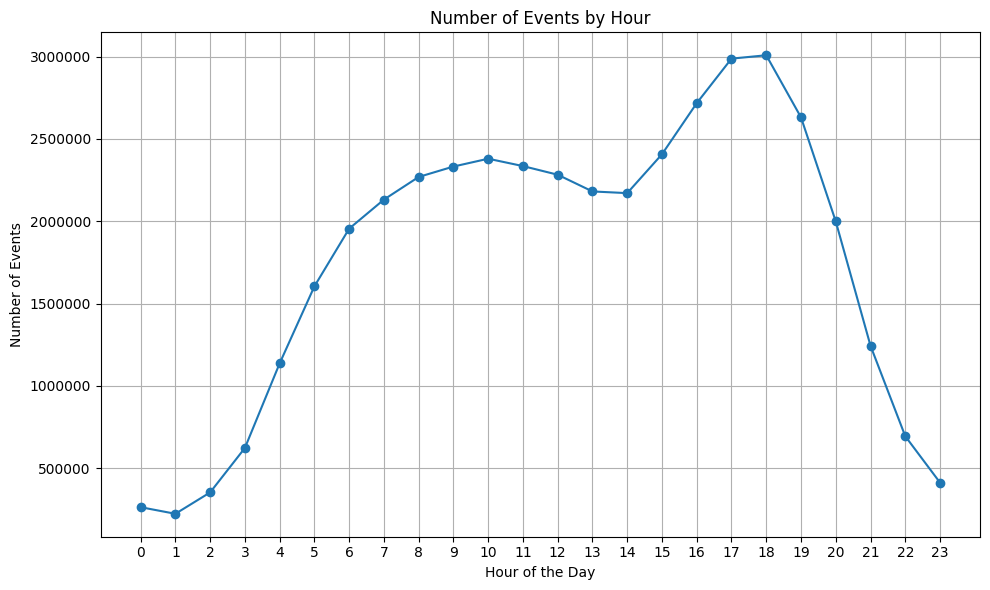

Wall time: 0.277 s
RSS Δ: +4.88 MB
Peak memory Δ: +4.88 MB (OS-dependent)


<ExecutionResult object at 742786b0b550, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 742786b0a710, raw_cell="# codecell_36c (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [42]:
%%timemem
# codecell_36c (keep this id for tracking purposes)

import matplotlib.pyplot as plt

events_by_hour_pdf = events_by_hour_df.toPandas()


plt.figure(figsize=(10,6))
plt.plot(events_by_hour_pdf['hour'], events_by_hour_pdf['event_count'], marker='o', linestyle='-')
plt.title("Number of Events by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Events")
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(range(0, 24))  
plt.grid(True)
plt.tight_layout()
plt.show()


plt.show()

### 3.7 Q7

We are going to analyze the "big" brands. Find out the average purchase price by brand, and restrict to cases where the average is more than 10K.
We want the results sorted by the average purchase price from the largest to smallest value.
(Report answers to two digits after the decimal point, i.e., XX.XX, but it's okay if the output only contains one digit after the decimal point.)

First, do it using SQL:

In [43]:
%%timemem
# codecell_37a (keep this id for tracking purposes)

# Write your SQL below
sql_query = f"""
SELECT 
    p.brand_code,
    ROUND(AVG(e.price), 2) AS avg_price
FROM events e
JOIN products p
    ON e.product_key = p.product_key
WHERE e.event_type = 'purchase'
GROUP BY p.brand_code
HAVING AVG(e.price) > 10000
ORDER BY avg_price DESC;
"""

results = spark.sql(sql_query)

results.show()

[Stage 88:==========================================>             (16 + 5) / 21]

+----------+---------+
|brand_code|avg_price|
+----------+---------+
|      adam|  58946.0|
|      kona|  43759.0|
|  yuandong|  35329.0|
|   bentley|  23164.0|
|      otex| 18633.14|
|    suunto| 10732.82|
|     stark| 10400.25|
+----------+---------+

Wall time: 2.341 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 742786af6260, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 742786af63b0, raw_cell="# codecell_37a (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

Next, do it with DataFrames:

In [49]:
from pyspark.sql.functions import col, avg, round as spark_round

In [76]:
%%timemem
# codecell_37b (keep this id for tracking purposes)
avg_price_by_brand_df = (
    events_df
    .filter(col("event_type") == "purchase")
    .join(products_df, on="product_key")   
    .groupBy("brand_code")                 
    .agg(spark_round(avg("price"), 2).alias("avg_price")) 
    .filter(col("avg_price") > 10000)        
    .orderBy(col("avg_price").desc())         
)

avg_price_by_brand_df.show()
avg_price_by_brand_df.explain(mode='formatted')


+----------+---------+
|brand_code|avg_price|
+----------+---------+
|      adam|  58946.0|
|      kona|  43759.0|
|  yuandong|  35329.0|
|   bentley|  23164.0|
|      otex| 18633.14|
|    suunto| 10732.82|
|     stark| 10400.25|
+----------+---------+

== Physical Plan ==
AdaptiveSparkPlan (15)
+- Sort (14)
   +- Exchange (13)
      +- Filter (12)
         +- HashAggregate (11)
            +- Exchange (10)
               +- HashAggregate (9)
                  +- Project (8)
                     +- BroadcastHashJoin Inner BuildRight (7)
                        :- Project (3)
                        :  +- Filter (2)
                        :     +- Scan parquet  (1)
                        +- BroadcastExchange (6)
                           +- Filter (5)
                              +- Scan parquet  (4)


(1) Scan parquet 
Output [3]: [product_key#66, event_type#71, price#72]
Batched: true
Location: InMemoryFileIndex [file:/home/justine/Data_engineering/lab3_assignment/data/retail_dw_2

<ExecutionResult object at 742784de27d0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 742784de3ac0, raw_cell="# codecell_37b (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

When you run the cell above, `avg_price_by_brand_df` should be something like:

```
+----------+------------------+
|brand_code|         avg_price|
+----------+------------------+
|       ???|               ???|
        ...
|       ???|               ???|
+----------+------------------+
```

Now plot the above DataFrame using `matplotlib`.
Here we want a bar chart, with each of the brands as a bar, and the average price on the _y_ axis.

**Hint:** use the code below to get started.

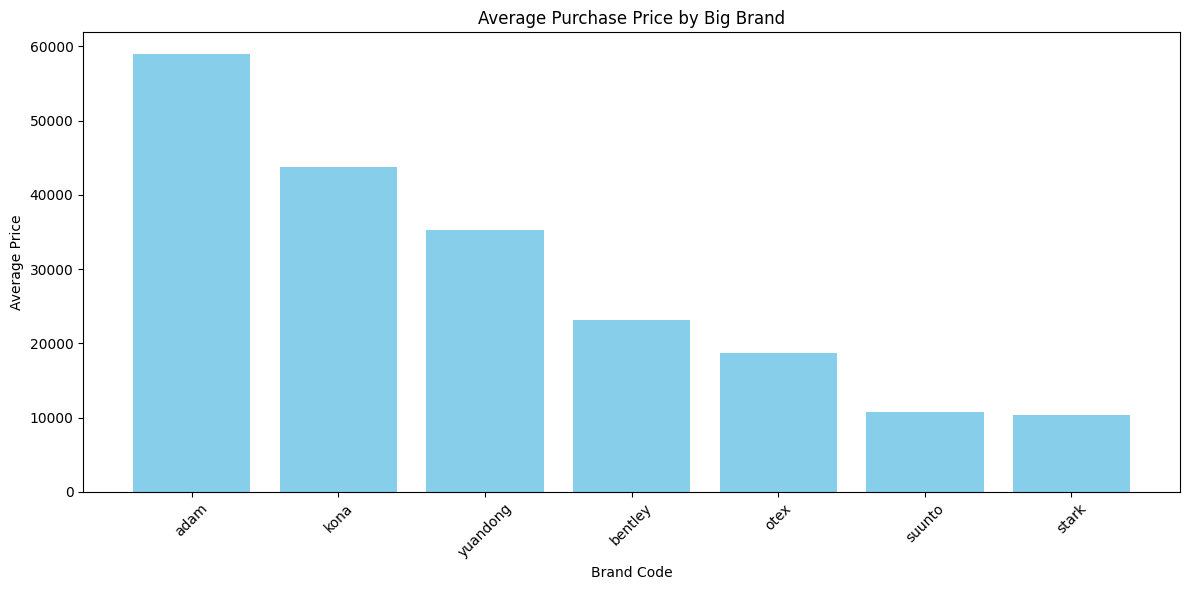

Wall time: 1.400 s
RSS Δ: +3.13 MB
Peak memory Δ: +5.88 MB (OS-dependent)


<ExecutionResult object at 742786d4d960, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 742786e28a60, raw_cell="# codecell_37c (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [53]:
%%timemem
# codecell_37c (keep this id for tracking purposes)

import matplotlib.pyplot as plt

avg_price_by_brand_pdf = avg_price_by_brand_df.toPandas()

plt.figure(figsize=(12,6)) 
plt.bar(
    avg_price_by_brand_pdf['brand_code'], 
    avg_price_by_brand_pdf['avg_price'], 
    color='skyblue'
)

plt.xlabel('Brand Code')  
plt.ylabel('Average Price')   
plt.title('Average Purchase Price by Big Brand')  
plt.xticks(rotation=45)      
plt.tight_layout()

plt.show()

## 4. Load RDDs

The remaining exercises focus on RDD manipulations.

Let's start by loading the RDDs.

In [54]:
# Get RDDs directly from DataFrames (with required repartitions)
# type: RDD[Row]
events_rdd   = events_df.rdd.repartition(1000)
products_rdd = products_df.rdd.repartition(100)
brands_rdd   = brands_df.rdd.repartition(100)

You'll need `Row`, so let's make sure we've imported it.

In [55]:
from pyspark.sql import Row

## 5. Implementations of Computing Averages

In this next exercise, we're going to implement "computing the mean" (version 1) and (version 3) in Spark as described in the second lecture **Batch Processing I** (please use ctrl+f to reach the slide with the title : "Computing the Mean: Version 1" or "Computing the Mean: Version 3".

To make the problem more tractable (i.e., to reduce the running times), let's first do a bit of filtering of the `events` table.
We'll do this using DataFrames, and then generate an RDD:

In [56]:
filtered_events_df = (
    events_df
        .filter((F.col("event_type") == "purchase") & F.col("price").isNotNull())
        .join(brands_df, on="brand_key")
)

filtered_events_df.count()

print(f"Number of rows in events          table: {events_df.count()}")
print(f"Number of rows in filtered events table: {filtered_events_df.count()}")

filtered_events_rdd = filtered_events_df.rdd

Number of rows in events          table: 42351862


[Stage 112:============================================>          (17 + 4) / 21]

Number of rows in filtered events table: 664885


You can confirm that we're working with a smaller dataset.

Compute the average purchase price by brand. We want the results sorted by the average purchase price from the largest to smallest value. As before, round to two digits after the decimal point. This is similar to Q7 above, except _without_ the "more than 10K" condition.

Implement using the naive **"version 1"** algorithm, as described in the lectures:

+ You _must_ start with `filtered_events_rdd`.
+ You _must_ use `groupByKey()`.
+ Per "version 1", your implementation _must_ shuffle all values from the "mappers" to the "reducers".

**write some code here**

In [57]:
%%timemem
# codecell_5x1 (keep this id for tracking purposes)

brand_price_rdd = filtered_events_rdd.map(lambda e: (e['brand_code'], e['price']))
brand_grouped_rdd = brand_price_rdd.groupByKey()
average_revenue_per_brand_v1 = brand_grouped_rdd.mapValues(lambda prices: round(sum(prices) / len(prices), 2))
average_revenue_per_brand_v1 = average_revenue_per_brand_v1.sortBy(lambda x: x[1], ascending=False)

average_revenue_per_brand_v1.take(10)

[('adam', 58946.0),
 ('kona', 43759.0),
 ('yuandong', 35329.0),
 ('bentley', 23164.0),
 ('otex', 18633.13),
 ('suunto', 10732.82),
 ('stark', 10400.25),
 ('zenmart', 9447.0),
 ('baltekstil', 8504.19),
 ('bugati', 8288.42)]

Wall time: 14.266 s
RSS Δ: +0.25 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 742786427fa0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 742786427fd0, raw_cell="# codecell_5x1 (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=[('adam', 58946.0), ('kona', 43759.0), ('yuandong', 35329.0), ('bentley', 23164.0), ('otex', 18633.13), ('suunto', 10732.82), ('stark', 10400.25), ('zenmart', 9447.0), ('baltekstil', 8504.19), ('bugati', 8288.42)]>

Compute the average purchase price by brand. We want the results sorted by the average purchase price from the largest to smallest value. As before, round to two digits after the decimal point. This is similar to Q7 above, except _without_ the "more than 10K" condition.

Implement using the improved **"version 3"** algorithm, as described in the lectures:

+ You _must_ start with `filtered_events_rdd`.
+ You _must_ use `reduceByKey()`.
+ Per "version 3", your implementation _must_ emit `(sum, count)` pairs and take advantage opportunities to perform aggregations.

**write some code here**

In [58]:
%%timemem
# codecell_5x2 (keep this id for tracking purposes)

brand_sum_count_rdd = filtered_events_rdd.map(lambda e: (e['brand_code'], (e['price'], 1)))
brand_aggregated_rdd = brand_sum_count_rdd.reduceByKey(lambda a, b: (a[0]+b[0], a[1]+b[1]))
average_revenue_per_brand_v3 = brand_aggregated_rdd.mapValues(lambda x: round(x[0] / x[1], 2))
average_revenue_per_brand_v3 = average_revenue_per_brand_v3.sortBy(lambda x: x[1], ascending=False)
average_revenue_per_brand_v3.take(10)

[('adam', 58946.0),
 ('kona', 43759.0),
 ('yuandong', 35329.0),
 ('bentley', 23164.0),
 ('otex', 18633.13),
 ('suunto', 10732.82),
 ('stark', 10400.25),
 ('zenmart', 9447.0),
 ('baltekstil', 8504.19),
 ('bugati', 8288.42)]

Wall time: 10.759 s
RSS Δ: +0.38 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 742786425480, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 742786d4fb80, raw_cell="# codecell_5x2 (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=[('adam', 58946.0), ('kona', 43759.0), ('yuandong', 35329.0), ('bentley', 23164.0), ('otex', 18633.13), ('suunto', 10732.82), ('stark', 10400.25), ('zenmart', 9447.0), ('baltekstil', 8504.19), ('bugati', 8288.42)]>

## 6. Implementations of Joins

Next, we're going to implement joins.

Our join implementations will be general, but we're going to check correctness using the following query:

In [59]:
spark.sql("""

SELECT * FROM brands b
JOIN products p ON p.brand_key = b.brand_key
WHERE b.brand_key = '423'

""").show()

+----------+--------------------+---------+-------------+----------+----------+------------+--------------------+---------+------------+-----------+
|brand_code|          brand_desc|brand_key|category_code|brand_code|product_id|product_name|        product_desc|brand_key|category_key|product_key|
+----------+--------------------+---------+-------------+----------+----------+------------+--------------------+---------+------------+-----------+
| blaupunkt|"Blaupunkt is a G...|      423|  electronics| blaupunkt|   1802099|    video.tv|The video.tv is a...|      423|           8|       4813|
| blaupunkt|"Blaupunkt is a G...|      423|  electronics| blaupunkt|   1802107|    video.tv|The video.tv is a...|      423|           8|       4821|
+----------+--------------------+---------+-------------+----------+----------+------------+--------------------+---------+------------+-----------+



### 6.1 Shuffle Join Implementation

Here, we're going to implement a shuffle join, aka reduce-side join.

Write the function `shuffle_join`, as follows:
+ Takes in `R`, `S`, `keyR`, and `keyS`: `R` and `S` are the RDDs to be joined; `keyR` and `keyS` are the join keys in `R` and `S`, respectively (type string).
+ The output is an RDD of `Row`s that corresponds to the inner join on the keys.

The function should implement a shuffle join between the two RDDs (as discussed in lecture).
Specifically:
+ You _cannot_ use the `join` (or any related) transformation on RDDs, because that would defeat the point of the exercise.
+ If you have any additional questions about allowed or disallowed transformations, ask!

Note that in SQL, `keyR` and `keyS` are repeated in the joined output (i.e., you get duplicate columns).
Here, you just want one copy.
Hint: Concatenate the `Row`s but keep only one copy of the join key.

**write some code here**

In [90]:
# codecell_61a (keep this id for tracking purposes)

def shuffle_join(R, S, keyR, keyS):
    R_mapped = R.map(lambda r: (r[keyR], ("R", r)))
    S_mapped = S.map(lambda s: (s[keyS], ("S", s)))
    joined = R_mapped.union(S_mapped).groupByKey()
    
    def combine(rows):
        rows_R = [r for t, r in rows if t == "R"]
        rows_S = [s for t, s in rows if t == "S"]
        return [Row(**{**r.asDict(), **{k: v for k, v in s.asDict().items() if k != keyS}}) 
                for r in rows_R for s in rows_S]
    
    return joined.flatMapValues(combine).values()



Let's try to use it!

In [91]:
%%timemem

shuffle_join_rdd = shuffle_join(brands_rdd, products_rdd, "brand_key", "brand_key")
shuffle_join_rdd.count()

115584

Wall time: 23.619 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 742786d86f20, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 742786d871f0, raw_cell="
shuffle_join_rdd = shuffle_join(brands_rdd, produ.." store_history=False silent=False shell_futures=True cell_id=None> result=115584>

Add in the `WHERE` clause:

In [93]:
shuffle_join_results_rdd = shuffle_join_rdd.filter(lambda row: row["brand_key"] == 423)
shuffle_join_results_rdd.count()

2

If you look at the results, they're a bit difficult to read... why don't we just use Spark DataFrames for prettification?

In [63]:
df = spark.createDataFrame(shuffle_join_results_rdd.collect())
df.show()

+----------+--------------------+---------+-------------+----------+------------+--------------------+------------+-----------+
|brand_code|          brand_desc|brand_key|category_code|product_id|product_name|        product_desc|category_key|product_key|
+----------+--------------------+---------+-------------+----------+------------+--------------------+------------+-----------+
| blaupunkt|"Blaupunkt is a G...|      423|  electronics|   1802099|    video.tv|The video.tv is a...|           8|       4813|
| blaupunkt|"Blaupunkt is a G...|      423|  electronics|   1802107|    video.tv|The video.tv is a...|           8|       4821|
+----------+--------------------+---------+-------------+----------+------------+--------------------+------------+-----------+



Verify output against the SQL query.

### 6.2 Replicated Hash Join Implementation

Here, we're going to implement a replicated hash join.

Write the function `replicated_hash_join`, as follows:
+ Takes in `R`, `S`, `keyR`, and `keyS`: `R` and `S` are the RDDs to be joined; `keyR` and `keyS` are the join keys in `R` and `S`, respectively (type string).
+ The output is an RDD of `Row`s that corresponds to the inner join on the keys.

The function should implement a hash join between the two RDDs (as discussed in lecture).
Specifically:
+ `R` is the dataset you load into memory and replicate.
+ You _cannot_ use the `join` (or any related) transformation on RDDs, because that would defeat the point of the exercise.
+ If you have any additional questions about allowed or disallowed transformations, ask!

Note that in SQL, `keyR` and `keyS` are repeated in the joined output (i.e., you get duplicate columns).
Here, you just want one copy.
Hint: Concatenate the `Row`s but keep only one copy of the join key.

**write some code here**

In [64]:
# codecell_62a (keep this id for tracking purposes)

def replicated_hash_join(R, S, keyR, keyS):
    R_dict = R.map(lambda r: (r[keyR], r)).groupByKey().mapValues(list).collectAsMap()
    R_broadcast = sc.broadcast(R_dict)

    def join_with_broadcast(s):
        key = s[keyS]
        if key in R_broadcast.value:
            return [
                Row(**{**r.asDict(), **{k: v for k, v in s.asDict().items() if k != keyS}})
                for r in R_broadcast.value[key]
            ]
        else:
            return []

    return S.flatMap(join_with_broadcast)



Let's try to use it!

In [65]:
%%timemem

replicated_hash_join_rdd = replicated_hash_join(brands_rdd, products_rdd, "brand_key", "brand_key")
replicated_hash_join_rdd.count()

115584

Wall time: 13.348 s
RSS Δ: -3.15 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 74278649bac0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 742786d4d570, raw_cell="
replicated_hash_join_rdd = replicated_hash_join(b.." store_history=False silent=False shell_futures=True cell_id=None> result=115584>

Add in the `WHERE` clause:

In [66]:
replicated_hash_join_results_rdd = replicated_hash_join_rdd.filter(lambda row: row["brand_key"] == 423)
replicated_hash_join_results_rdd.count()

2

If you look at the results, they're a bit difficult to read... why don't we just use Spark DataFrames for prettification?

In [74]:
df = spark.createDataFrame(replicated_hash_join_results_rdd.collect())
df.show()
df.explain(mode='formatted')

+----------+--------------------+---------+-------------+----------+------------+--------------------+------------+-----------+
|brand_code|          brand_desc|brand_key|category_code|product_id|product_name|        product_desc|category_key|product_key|
+----------+--------------------+---------+-------------+----------+------------+--------------------+------------+-----------+
| blaupunkt|"Blaupunkt is a G...|      423|  electronics|   1802099|    video.tv|The video.tv is a...|           8|       4813|
| blaupunkt|"Blaupunkt is a G...|      423|  electronics|   1802107|    video.tv|The video.tv is a...|           8|       4821|
+----------+--------------------+---------+-------------+----------+------------+--------------------+------------+-----------+

== Physical Plan ==
* Scan ExistingRDD (1)


(1) Scan ExistingRDD [codegen id : 1]
Output [9]: [brand_code#578, brand_desc#579, brand_key#580L, category_code#581, product_id#582L, product_name#583, product_desc#584, category_key#58

Verify output against the SQL query.

## 7. Join Performance

Now that we have two different implementations of joins, let's compare them, on the _same exact query_.
The first two are repeated from above.

Let's call this J1 below.
(Run the cell, it should just work. If it doesn't you'll need to fix the implementation above.)

In [72]:
%%timemem

shuffle_join_rdd = shuffle_join(brands_rdd, products_rdd, "brand_key", "brand_key").filter(lambda row: row["brand_key"] == 423)
shuffle_join_rdd.count()

2

Wall time: 26.484 s
RSS Δ: -3.84 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 742786af5960, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 742786af58d0, raw_cell="
shuffle_join_rdd = shuffle_join(brands_rdd, produ.." store_history=False silent=False shell_futures=True cell_id=None> result=2>

Let's call this J2 below.
(Run the cell, it should just work. If it doesn't you'll need to fix the implementation above.)

In [71]:
%%timemem

replicated_hash_join_rdd = replicated_hash_join(brands_rdd, products_rdd, "brand_key", "brand_key").filter(lambda row: row["brand_key"] == 423)
replicated_hash_join_rdd.count()

2

Wall time: 10.911 s
RSS Δ: -21.79 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 742778ba1b40, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 742778ba1b70, raw_cell="
replicated_hash_join_rdd = replicated_hash_join(b.." store_history=False silent=False shell_futures=True cell_id=None> result=2>

Let's call this J3 below.
(Run the cell, it should just work. If it doesn't you'll need to fix the implementation above.)

In [73]:
%%timemem

replicated_hash_join_rdd = replicated_hash_join(products_rdd, brands_rdd, "brand_key", "brand_key").filter(lambda row: row["brand_key"] == 423)
replicated_hash_join_rdd.count()

2

Wall time: 24.189 s
RSS Δ: +53.30 MB
Peak memory Δ: +13.39 MB (OS-dependent)


<ExecutionResult object at 742786af7ca0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 742786af7760, raw_cell="
replicated_hash_join_rdd = replicated_hash_join(p.." store_history=False silent=False shell_futures=True cell_id=None> result=2>

J1, J2, and J3 should give you exactly the same results.
After all, they're just different implementations of the same query.

Answer the questions below.

**Put your answers below!**

// qcell_7x1290 (keep this id for tracking purposes)

**What are the running times of J1, J2, and J3**?
(You might want to run the cells a few times and take the average.)

- **Running time of J1:** <font color="red">26.4</font> seconds
- **Running time of J2:** <font color="red">10.9</font> seconds
- **Running time of J3:** <font color="red">24.1</font> seconds

**Explain:**

+ If the running times are what you expect, explain why X > Y > Z.
+ If the running times are _not_ what you expect, explain what they _should_ be, and then explain why X > Y > Z.
+ Specifically compare J2 and J3.

**Your answer?**

J1 – Shuffle Join (reduce-side join)

This is a full shuffle join: all values for the join keys are sent across the cluster to reducers.
Shuffling is expensive so it is the slowest among the three.

J2 – Replicated Hash Join (small table in memory)

One table is small enough to fit entirely in memory and is replicated to all workers.
Only the larger table needs to be scanned and probed against the in-memory hash table.
No shuffle is needed for the large table; therefore, it is the fastest, which matches the expectation.

J3 – Replicated Hash Join but with large table in memory

Here, the first RDD passed to the join is the large table (R), so Spark tries to replicate it to all workers.
This can be very costly in terms of memory and network I/O, because a large dataset is being broadcasted.
So J3 is slower than J2, even approaching the shuffle join time.

Comparison J2 vs J3:

J2 is faster because it correctly broadcasts the small table.
J3 is slower because it broadcasts a large table, which defeats the main advantage of a replicated hash join.

# 8. Submission

Details about the Submission of this assignment are outlined in the helper.

In [75]:
spark.conf.set("spark.sql.shuffle.partitions", 4)

In [94]:
%%timemem
spark.stop()

Wall time: 1.007 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 742786c8a980, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 742786d87130, raw_cell="spark.stop()
" store_history=False silent=False shell_futures=True cell_id=None> result=None>

## Performance notes
- Set and justify `spark.sql.shuffle.partitions` for local vs. cluster runs.
- Prefer DataFrame built-ins over Python UDFs; push logic to Catalyst when possible.
- Use **AQE** (adaptive query execution) to mitigate skew; consider salting for extreme keys.
- Cache only when reuse exists; unpersist when no longer needed.
- Use **broadcast join** only when the small side fits in memory; verify with `explain`.
- Capture `df.explain(mode='formatted')` for at least one analysis query and one join.
- A3 note: Python RDDs cross the Python/JVM boundary; slower runtimes are expected for the RDD parts.

## Self-check (toy data)

In [78]:
def rdd_mean(rdd):
    total = rdd.reduce(lambda x, y: x + y)
    count = rdd.count()
    return total / count

In [83]:
from pyspark import SparkContext

def shuffle_join(R, S, keyR=0, keyS=0):
    r_kv = R.map(lambda x: (x[keyR], x))
    s_kv = S.map(lambda x: (x[keyS], x))
    
    joined = r_kv.cogroup(s_kv)
    
    def combine(values):
        r_values, s_values = values
        return [(r + s[1:]) for r in r_values for s in s_values]
    
    return joined.flatMap(lambda kv: combine(kv[1]))

def replicated_hash_join(R, S, keyR=0, keyS=0):
    small = {k: v for k, *v in R.collect()} 
    
    def map_join(s_elem):
        k = s_elem[keyS]
        if k in small:
            return [tuple([k] + list(small[k]) + list(s_elem[1:]))]
        else:
            return []
    
    return S.flatMap(map_join)



In [84]:
if spark is not None:
    a = spark.sparkContext.parallelize([1, 2, 3, 4])
    mean_a = a.mean()
    print("Moyenne de a :", mean_a)

    left = spark.sparkContext.parallelize([(1, 'A'), (2, 'B'), (3, 'C')])
    right = spark.sparkContext.parallelize([(1, 10), (2, 20)])

    shuffle_result = shuffle_join(left, right, keyR=0, keyS=0)
    print("Résultat du shuffle join :")
    print(shuffle_result.collect())

    replicated_result = replicated_hash_join(left, right, keyR=0, keyS=0)
    print("Résultat du replicated hash join :")
    print(replicated_result.collect())


Moyenne de a : 2.5
Résultat du shuffle join :


[(1, 'A', 10), (2, 'B', 20)]
Résultat du replicated hash join :
[(1, 'A', 10), (2, 'B', 20)]


## Reproducibility checklist
- Record Python, Java, and Spark versions.
- Fix timezone to UTC and log run timestamp.
- Pin random seeds where randomness is used.
- Save configs: `spark.sql.shuffle.partitions`, AQE flags, broadcast thresholds if changed.
- Provide exact run commands and input/output paths.
- Export a minimal environment file (`environment.yml` or `requirements.txt`).
- Keep data paths relative to project root; avoid user-specific absolute paths.
- Include small sample outputs for verification.
